<a href="https://colab.research.google.com/github/UssiShah/Projects/blob/main/DuckDB%20clickstream%20study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

*Before you start reading, please configure your environment as described in the "Before you get started" README section of your GitHub repository.*

The assignment consists of a [DuckDB](https://duckdb.org/) database with three tables of clickstream data. The data resembles what we use at Mentimeter to track user behaviour in the product.

You're tasked to explore the data and develop queries or code for creating three data models that could be used within the organisation.

Feel free to explore the data in as many cells as you want, but we'd like the handin to be concise with your solution in the placeholder cells only.

## Database tables

**presentation_activity**

| name         | type      | notnull |
| ------------ | --------- | ------- |
| user_id      | INTEGER   | True    |
| triggered_at | TIMESTAMP | True    |
| action       | VARCHAR   | False   |
| browser      | VARCHAR   | False   |
| device       | VARCHAR   | False   |
| os           | VARCHAR   | False   |

**registrations**

| name         | type    | notnull |
| ------------ | ------- | ------- |
| user_id      | INTEGER | True    |
| triggered_at | BIGINT  | True    |
| browser      | VARCHAR | False   |
| device       | VARCHAR | False   |
| os           | VARCHAR | False   |

**view_activity**

| name         | type      | notnull |
| ------------ | --------- | ------- |
| user_id      | INTEGER   | True    |
| triggered_at | TIMESTAMP | True    |
| page         | VARCHAR   | False   |
| browser      | VARCHAR   | False   |
| device       | VARCHAR   | False   |
| os           | VARCHAR   | False   |


## Solution requirements

### Analytics Engineer applicant

If you're applying to an Analytics Engineer role, please solve at least two of Task 2-4 using SQL. You may solve a third one using Pandas if you want. If you want to use Pandas, you can choose any task to solve with it.

### Data Engineer applicant

If you're applying to an Data Engineer role, please solve one of the tasks using SQL and another in Pandas. The third one you may choose either alternative. It's up to you to pick which task to use which method for.

#### Pandas based solution

For Pandas based solutions, you need to read dataframes from the database. Do so by simply getting a dataframe with all the data, and only use Pandas for your transformations: `SELECT * FROM table;`

### Setup

In [ ]:
!git clone https://github.com/afcef77a-55e4-4bcd-830c-6151adaba7bc/data-sets
!pip install duckdb==0.4.0

### Task 1

There are some issues/inconsistencies in the data affecting the requested data models. If you find them, please note what they are and share a comment or two on your thoughts around them. We might discuss these problems further in the competence interview.


OBSERVATIONS:
1. Same timestamp range between tables (at least the first 2)
2. All of user_ids in Registrations table were found in the presentation activity table
3. Registrations contains user_id as PK which is a FK for the other columns.
4. There are many presentation and view activities on single users

BUGS:



Registraions table:
1. Triggered_at is BIGINT

Presentation activity table:
1. Action -> 'Presentation receives votes' equals actual presentation... could be a wrong assumption.

### Task 2

Create a data model with the amount of new user registrations per day.

In [101]:
# ANSWER 2

# SQL based placeholder solution
import duckdb
import pandas as pd

con = duckdb.connect(database="data-sets/clickstreams.duckdb", read_only=True)
query_2 = """
  WITH reg AS (
    SELECT r.user_id as R_user_id,
         date_trunc('day', to_timestamp(r.triggered_at)) as R_triggered_at, -- Converted to timestamp to DATE
         r.browser as R_browser,
         r.device as R_device,
         r.os as R_os
    FROM registrations r
  )
  SELECT R_triggered_at AS DATE,
        COUNT(DISTINCT R_user_id) AS NEW_USER_REGISTRATIONS
  FROM reg
  GROUP BY 1
"""
answer_2 = con.execute(query_2).df()
#print(answer_2)
#con.close()
answer_2

,DATE,NEW_USER_REGISTRATIONS
0,2022-07-28,11745
1,2022-07-29,9116
2,2022-07-27,11464
3,2022-07-26,11228
4,2022-07-25,8381


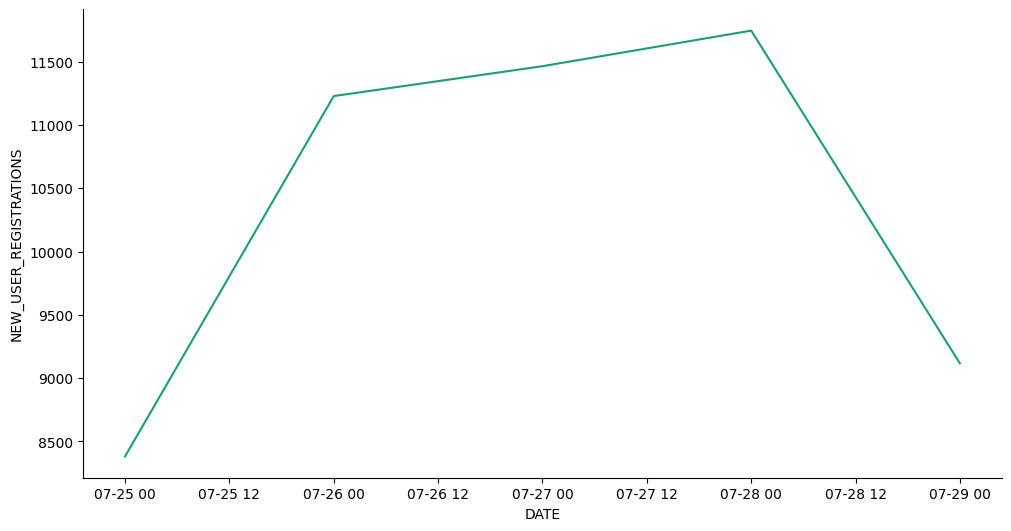

In [103]:
# @title DATE vs NEW_USER_REGISTRATIONS

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['DATE']
  ys = series['NEW_USER_REGISTRATIONS']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = answer_2.sort_values('DATE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DATE')
_ = plt.ylabel('NEW_USER_REGISTRATIONS')

### Task 3

Create a data model with two columns; one with amount of unique users editing presentations and another with amount of unique users presenting presentations for an audience (presentation receives votes) per day.

In [60]:
# ANSWER 3

# SQL based placeholder solution
import duckdb
import pandas as pd

con = duckdb.connect(database="data-sets/clickstreams.duckdb", read_only=True)
query_2 = """
  WITH pre_act AS (
    SELECT pa.user_id as PA_user_id,
         date_trunc('day', pa.triggered_at) as PA_triggered_at, -- Converted to DAY
         pa.action as PA_action,
         pa.browser as PA_browser,
         pa.device as PA_device,
         pa.os as PA_os,
  FROM presentation_activity pa
  ),
  transformed AS (
    SELECT
      PA_triggered_at,                                          -- Date
      SUM(CASE
        WHEN PA_action = 'changed font size' THEN 1
        ELSE 0
      END) AS ACT1,                                             -- Create a new column that counts the occurance of edit

      SUM(CASE
        WHEN PA_action = 'created question' THEN 1
        ELSE 0
      END) AS ACT2,                                             -- Create a new column that counts the occurance of edit

      SUM(CASE
        WHEN PA_action = 'changed theme' THEN 1
        ELSE 0
      END) AS ACT3,                                             -- Create a new column that counts the occurance of edit

      SUM(CASE
        WHEN PA_action = 'changed color' THEN 1
        ELSE 0
      END) AS ACT4,                                             -- Create a new column that counts the occurance of edit

      SUM(CASE
        WHEN PA_action = 'presentation received votes' THEN 1
        ELSE 0
      END) AS PRESENT,                                          -- Create a new column that counts the occurance of presentation

    FROM pre_act
    GROUP BY 1
  )
  SELECT
    PA_triggered_at,
    (ACT1 + ACT2 + ACT3 + ACT4)::INT AS EDIT,                  -- Changing dtype from float to int
    PRESENT
  FROM transformed

"""
answer_2 = con.execute(query_2).df()
#print(answer_2)
#con.close()

new_df = answer_2.set_index('PA_triggered_at')                 # Set the column as the index
new_df

,EDIT,PRESENT
PA_triggered_at,,
2022-07-25,18202,1246.0
2022-07-29,25808,3385.0
2022-07-27,31467,3274.0
2022-07-28,30513,3736.0
2022-07-26,26794,2511.0


### Task 4

Create a data model of the amount of users who edit presentations within 24 hours of their registration per day.

In [93]:
# ANSWER 4

# SQL based placeholder solution
import duckdb
import pandas as pd

con = duckdb.connect(database="data-sets/clickstreams.duckdb", read_only=True)
query_2 = """
  WITH transformed AS (
    SELECT pa.user_id as PA_user_id,
          pa.triggered_at as PA_triggered_at,
          pa.action as PA_action,
          pa.browser as PA_browser,
          pa.device as PA_device,
          pa.os as PA_os,

          r.user_id as R_user_id,
          to_timestamp(r.triggered_at) as R_triggered_at,                       -- Converted to timestamp
          r.browser as R_browser,
          r.device as R_device,
          r.os as R_os

    FROM presentation_activity pa
    LEFT JOIN registrations r
    ON pa.user_id = r.user_id
    WHERE PA_action != 'presentation received votes'                            -- Kept only the edit actions
    AND DATE_DIFF('hour', R_triggered_at, PA_triggered_at) <= 24                -- Kept +24h range
  )
    SELECT date_trunc('day', R_triggered_at) AS DATE,                           -- Converted to Date
           COUNT(DISTINCT R_user_id) AS USERS_EDITED_IN_24H                     -- Counted uniques
    FROM transformed
    GROUP BY 1
"""
#  SELECT date_trunc('day', R_triggered_at) AS DATE,
#         COUNT(DISTINCT R_user_id) AS USERS_EDITED_IN_24H
#  FROM transformed
#  GROUP BY 1



answer_2 = con.execute(query_2).df()
#print(answer_2)
#con.close()
answer_2#['triggered_at'].describe()

,DATE,USERS_EDITED_IN_24H
0,2022-07-26,6159
1,2022-07-27,6040
2,2022-07-28,6064
3,2022-07-29,4614
4,2022-07-25,4505


## EXPLORATORY DATA ANALYSIS:

In [99]:
# EDA:

# EDA: JOINED


# SQL based placeholder solution
import duckdb
import pandas as pd

con = duckdb.connect(database="data-sets/clickstreams.duckdb", read_only=True)
query_2 = """
  SELECT COUNT(DISTINCT user_id)
  FROM presentation_activity

"""
answer_2 = con.execute(query_2).df()
#print(answer_2)
#con.close()
answer_2

,count(DISTINCT user_id)
0,28841


In [ ]:
# EDA: JOINED


# SQL based placeholder solution
import duckdb
import pandas as pd

con = duckdb.connect(database="data-sets/clickstreams.duckdb", read_only=True)
query_2 = """
  SELECT pa.user_id as PA_user_id,
         pa.triggered_at as PA_triggered_at,
         pa.action as PA_action,
         pa.browser as PA_browser,
         pa.device as PA_device,
         pa.os as PA_os,

         r.user_id as R_user_id,
         to_timestamp(r.triggered_at) as R_triggered_at, -- Converted to timestamp
         r.browser as R_browser,
         r.device as R_device,
         r.os as R_os,



  FROM presentation_activity pa
  FULL OUTER JOIN registrations r
  ON pa.user_id = r.user_id
  FULL OUTER JOIN view_activity
  ON r.user_id =
"""
answer_2 = con.execute(query_2).df()
#print(answer_2)
#con.close()
answer_2

In [ ]:
# EDA: REGISTRATIONS

# SQL based placeholder solution
import duckdb
import pandas as pd

con = duckdb.connect(database="data-sets/clickstreams.duckdb", read_only=True)
query_2 = """
  WITH reg AS (
    SELECT r.user_id as R_user_id,
         date_trunc('day', to_timestamp(r.triggered_at)) as R_triggered_at, -- Converted to timestamp to DATE
         r.browser as R_browser,
         r.device as R_device,
         r.os as R_os
    FROM registrations r
  )
  SELECT *
  FROM reg
"""
answer_2 = con.execute(query_2).df()
#print(answer_2)
#con.close()
answer_2

In [109]:
# EDA: PRESENTATION ACTIVITY

# SQL based placeholder solution
import duckdb
import pandas as pd

con = duckdb.connect(database="data-sets/clickstreams.duckdb", read_only=True)
query_2 = """
  WITH pre_act AS (
    SELECT pa.user_id as PA_user_id,
         date_trunc('day', pa.triggered_at) as PA_triggered_at, -- Converted to DAY
         pa.action as PA_action,
         pa.browser as PA_browser,
         pa.device as PA_device,
         pa.os as PA_os,
  FROM presentation_activity pa
  )
  SELECT *
  FROM pre_act
  WHERE PA_user_id = '66481016'
  AND PA_triggered_at = '2022-07-25'

"""
answer_2 = con.execute(query_2).df()
#print(answer_2)
#con.close()
answer_2

,PA_user_id,PA_triggered_at,PA_action,PA_browser,PA_device,PA_os
0,66481016,2022-07-25,created question,Chrome,desktop,Windows
1,66481016,2022-07-25,created question,Chrome,desktop,Windows
2,66481016,2022-07-25,presentation received votes,NaN,NaN,NaN
3,66481016,2022-07-25,changed font size,Chrome,desktop,Windows


In [ ]:
# EDA: VIEW_ACTIVITY

# SQL based placeholder solution
import duckdb
import pandas as pd

con = duckdb.connect(database="data-sets/clickstreams.duckdb", read_only=True)
query_2 = """
  WITH view_act AS (
    SELECT va.user_id as VA_user_id,
         va.triggered_at as VA_triggered_at,
         va.page as VA_page,
         va.browser as VA_browser,
         va.device as VA_device,
         va.os as VA_os,
  FROM view_activity va
  )
  SELECT *
  FROM view_act
"""
answer_2 = con.execute(query_2).df()
#print(answer_2)
#con.close()
answer_2